In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import torch.optim as optim
# Custom Data Loader pwd is ../Custom_Data_loader.py
from Custom_Data_loader import CustomDataset
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import numpy as np


In [65]:
transform = transforms.Compose([
    transforms.Resize((120, 160)),
    transforms.ToTensor(),
])

image_path_dir = 'Sample_Data/polargeist/polargeist_normal'
annot_path_dir = 'Sample_Data/polargeist/polargeist_hitbox'
image_paths = []
annot_paths = []
for i in range(1, 511):
    image_paths.append(image_path_dir + '/' + str(i) + '.png')
    annot_paths.append(annot_path_dir + '/' + str(i) + '.png')


dataset = CustomDataset(image_paths=image_paths,
                        annot_paths=annot_paths,
                        transform=transform)

# Split the dataset 

train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing



train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# # Test the dataset and DataLoader
# a_img = Image.open('Sample_Data/polargeist/polargeist_hitbox/1.png').convert("RGB")
# to_tensor_transform = transforms.ToTensor()
# a_img = to_tensor_transform(a_img) * 255.0
# f = dataset.create_multi_masks(a_img)
# CustomDataset.plot_multi_mask(f)

for images, masks in train_loader:
    print("Train batch - Images:", images.shape, "Masks:", masks.shape)
    break  # Just to check one batch, remove break to iterate through all batches

for images, masks in val_loader:
    print("Validation batch - Images:", images.shape, "Masks:", masks.shape)
    break  # Just to check one batch, remove break to iterate through all batches

for images, masks in test_loader:
    print("Test batch - Images:", images.shape, "Masks:", masks.shape)
    break  # Just to check one batch, remove break to iterate through all batches




Train batch - Images: torch.Size([8, 3, 120, 160]) Masks: torch.Size([8, 8, 120, 160])
Validation batch - Images: torch.Size([8, 3, 120, 160]) Masks: torch.Size([8, 8, 120, 160])
Test batch - Images: torch.Size([8, 3, 120, 160]) Masks: torch.Size([8, 8, 120, 160])


In [66]:
###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [78]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    ) 

class GDMapUNet(nn.Module):
    def __init__(self, n_classes):
        super(GDMapUNet, self).__init__()
        self.name = "GDMapUNet"
        self.downconv1 = double_conv(3, 64)
        self.downconv2 = double_conv(64, 128)
        self.downconv3 = double_conv(128, 256)
        self.downconv4 = double_conv(256, 512) 

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)     

        self.upconv1 = double_conv(256 + 512, 256)
        self.upconv2 = double_conv(128 + 256, 128)
        self.upconv3 = double_conv(128 + 64, 64)
        self.upconvSMAP = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        conv1 = self.downconv1(x)
        x = self.maxpool(conv1)

        conv2 = self.downconv2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.downconv3(x)
        x = self.maxpool(conv3)   
        
        x = self.downconv4(x)
        
        # feed in information from the encoder using concat skip connections

        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.upconv1(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.upconv2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        return self.upconvSMAP(self.upconv3(x))


In [49]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "GD_model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [79]:
import numpy as np

# Values we want to keep constant throughout the project


imshape_ = (120, 160, 3)
            # Class names:      # Class color  # Channel Number in target matrix
class_colors_ = {'platform':     (000,000,127), # 0
               'spike':          (127,000,000), # 1
               'player':         (255,255,255), # 2
               'yellow jump orb':(255,255,68), # 3
               'blue jump orb':  (17,255,255), # 4
               'blue pad':       (7,102,102), # 5
               'yellow pad':     (102,102,27), # 6
#              'background':     (000,000,000)  # 7 # Not needed as it is the default value
}

labels_ = class_colors_.keys()
n_classes_ = len(class_colors_) + 1 # +1 for background class

batch_size_ = 32  

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels




In [80]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [81]:
import time
def train_net(net, batch_size=4, learning_rate=0.01, num_epochs=30, checkpoint_interval=1):
    ########################################################################
    # Train a classifier on geodash data.
    torch.manual_seed(1000)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    # Set up some numpy arrays to store the training/test loss/err
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    start_time = time.time()

    inputs, labels = next(iter(train_loader))
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            predicted = (outputs > 0.0).squeeze().long()
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
            

        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")

        if epoch % checkpoint_interval == 0 or epoch == num_epochs - 1:
            model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
            print(f"Saving model to {model_path}")
            torch.save(net.state_dict(), model_path)

        print('Finished Training')
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Total time elapsed: {elapsed_time:.2f} seconds")

        # Write the train/test loss/err into CSV file for plotting later
        epochs = np.arange(1, num_epochs + 1)
        np.savetxt(f"{model_path}_train_err.csv", train_err)
        np.savetxt(f"{model_path}_train_loss.csv", train_loss)
        np.savetxt(f"{model_path}_val_err.csv", val_err)
        np.savetxt(f"{model_path}_val_loss.csv", val_loss)

In [83]:
train_net(GDMapUNet(n_classes_), batch_size=batch_size_, learning_rate=0.01, num_epochs=5, checkpoint_interval=1)

Epoch 1: Train err: 18273.176470588234, Train loss: 0.6295646945635478 | Validation err: 10644.078947368422, Validation loss: 0.5581409275531769
Saving model to GD_model_GDMapUNet_bs32_lr0.01_epoch0
Finished Training
Total time elapsed: 74.88 seconds
Epoch 2: Train err: 10308.78431372549, Train loss: 0.3174804810020659 | Validation err: 10644.078947368422, Validation loss: 0.1583675727248192
Saving model to GD_model_GDMapUNet_bs32_lr0.01_epoch1
Finished Training
Total time elapsed: 149.43 seconds
Epoch 3: Train err: 10308.78431372549, Train loss: 0.15651122364732956 | Validation err: 10644.078947368422, Validation loss: 0.1530265688896179
Saving model to GD_model_GDMapUNet_bs32_lr0.01_epoch2
Finished Training
Total time elapsed: 223.52 seconds
Epoch 4: Train err: 10308.78431372549, Train loss: 0.15395175649060144 | Validation err: 10644.078947368422, Validation loss: 0.15200770050287246
Saving model to GD_model_GDMapUNet_bs32_lr0.01_epoch3
Finished Training
Total time elapsed: 296.99 s

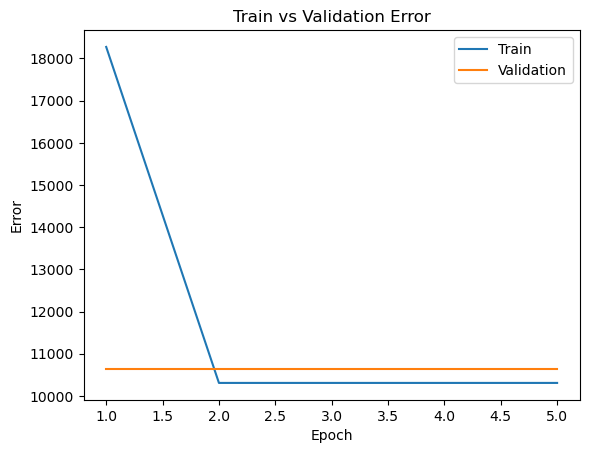

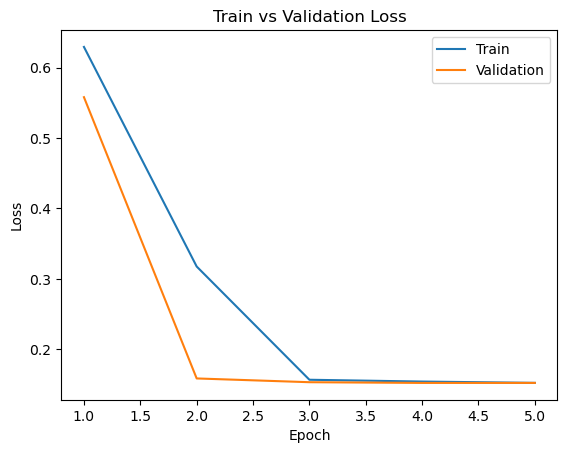

In [84]:
plot_training_curve("GD_model_GDMapUNet_bs32_lr0.01_epoch4")
